# Simple Flux Calculation
Here I analyse an experiment where I force the latent and sensible heat to only depend on surface temperature.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'q_surf', 'rho', 'ps', 'q_surf', 'ucomp', 'vcomp']  

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = 'simple_flux_calc_new'

mixed_layer_depth = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['depth']
w_atm_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['w_atm_const']
drag_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['drag_const']
rh_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['rh_const']
t_diseqb_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['t_diseqb_const']
p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['p_surf_const']
p_atm_approx = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['p_atm_const']

sigma_near_surf = p_atm_approx / p_surface_approx

lat_range = slice(25, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
use_time_start = 0
ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_base = ds_use.sel(time=slice(use_time_start, 100)).sel(lat=lat_range)      # only keep after spin up
ds_base = ds_base.sel(pfull=p_surface_approx, method='nearest').load()

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

In [4]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf*(1-sigma**(-kappa)) +temp_diseqb*sigma**(-kappa))

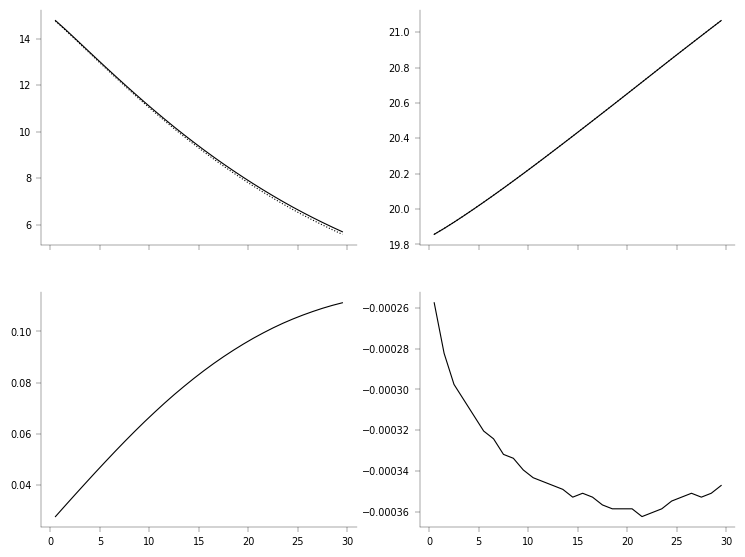

In [5]:
ind_lat_plot = -1
ind_lon_plot = 2

lh_calc = get_latent_heat(ds_base.t_surf, t_diseqb_const, rh_const, p_surface_approx, w_atm_const, drag_const)
sh_calc = get_sensible_heat(ds_base.t_surf, t_diseqb_const, p_surface_approx, w_atm_const, drag_const)
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
ax[0, 0].plot(ds_base.time, ds_base.flux_lhe.isel(lat=ind_lat_plot, lon=2), color='k')
ax[0, 0].plot(ds_base.time, lh_calc.isel(lat=ind_lat_plot, lon=2), color='k', linestyle=':')
ax[1, 0].plot(ds_base.time, (ds_base.flux_lhe-lh_calc).isel(lat=ind_lat_plot, lon=2), color='k')

ax[0, 1].plot(ds_base.time, ds_base.flux_t.isel(lat=ind_lat_plot, lon=2), color='k')
ax[0, 1].plot(ds_base.time, sh_calc.isel(lat=ind_lat_plot, lon=2), color='k', linestyle=':')
ax[1, 1].plot(ds_base.time, (ds_base.flux_t-sh_calc).isel(lat=ind_lat_plot, lon=2), color='k')

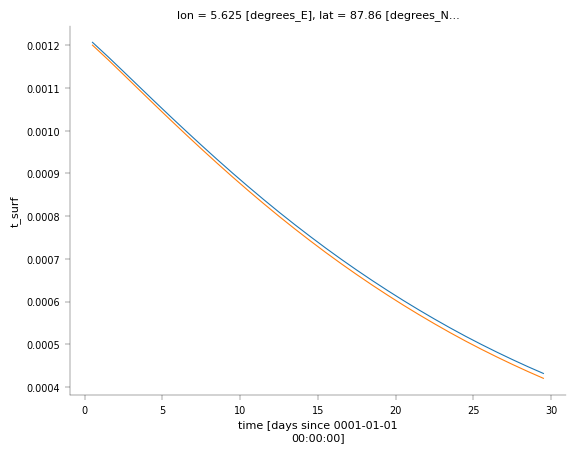

In [6]:
ds_base.q_surf.isel(lon=ind_lon_plot, lat=ind_lat_plot).plot()
sphum_sat(ds_base.t_surf, p_surface_approx).isel(lon=ind_lon_plot, lat=ind_lat_plot).plot()

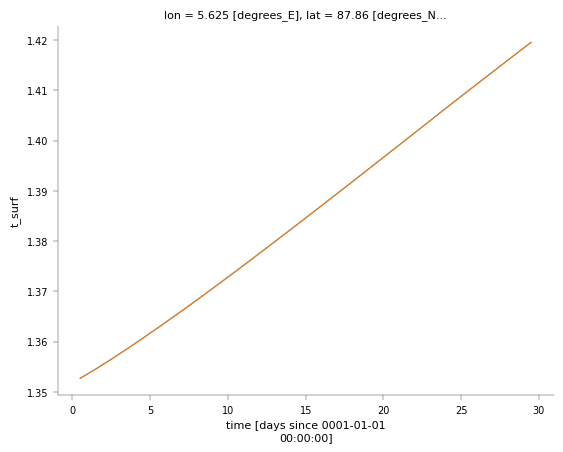

In [7]:
ds_base.rho.isel(lon=ind_lon_plot, lat=ind_lat_plot).plot()
get_density(ds_base.t_surf-t_diseqb_const, p_atm_approx).isel(lon=ind_lon_plot, lat=ind_lat_plot).plot()

In [8]:
# Take Annual Zonal Average
def get_annual_zonal_av(var, av_method='mean'):
    if av_method == 'mean':
        var_av = annual_mean(var).mean(dim='lon') 
    elif av_method == 'median':
        var_av = annual_mean(var).median(dim='lon')       # median to remove outlier influence
    return var_av.assign_coords(time=(var_av.time - var_av.time.min()).astype(int))